<a href="https://colab.research.google.com/github/AnishBehera05/Predictive_analysis_using_ML/blob/main/Predicting_Apple_Stock_Prices_with_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [106]:
# Load Apple stock price data
data = pd.read_csv('data.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [107]:
# Perform seasonal decomposition
result = seasonal_decompose(data['Close'], model='multiplicative', period=30)  # Adjust period as needed

In [108]:
# Split data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

In [109]:
# ARIMA model
model = ARIMA(train['Close'], order=(5, 1, 0))
arima_model = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [110]:
# Predictions
history = [x for x in train['Close']]
predictions = []
for t in range(len(test)):
    model = ARIMA(history, order=(5, 1, 0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test['Close'].iloc[t]
    history.append(obs)

In [111]:
# Predictions
model = ARIMA(train['Close'], order=(5, 1, 0))
arima_model = model.fit()
predictions = arima_model.forecast(steps=len(test))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

In [112]:
# Evaluate ARIMA model
error = mean_squared_error(test['Close'], predictions)
print('ARIMA Mean Squared Error:', error)

ARIMA Mean Squared Error: 1416.1559363767055


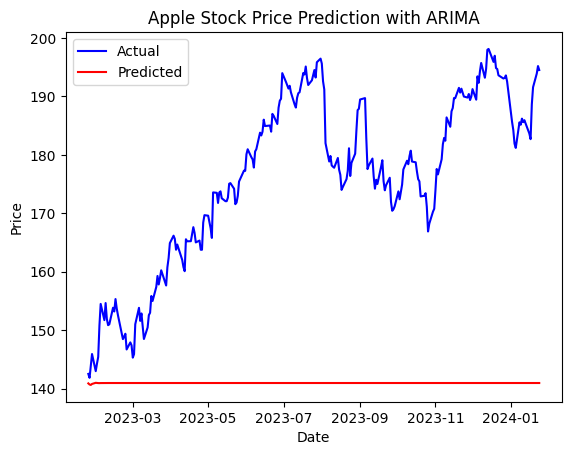

In [113]:
# Visualize predictions
plt.plot(test.index, test['Close'], color='blue', label='Actual')
plt.plot(test.index, predictions, color='red', label='Predicted')
plt.title('Apple Stock Price Prediction with ARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [115]:
# Load Apple stock price data
data = pd.read_csv('data.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [116]:
# Perform seasonal decomposition
result = seasonal_decompose(data['Close'], model='multiplicative', period=30)

In [117]:
# Split data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

In [118]:
# Fit an ARIMA model
model = ARIMA(train['Close'], order=(5, 1, 0))
arima_model = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [119]:
# Extract residuals
residuals = arima_model.resid

In [120]:
# Fit a GARCH model to the residuals
garch_model = arch_model(residuals, vol='GARCH', p=1, q=1)
garch_model_fit = garch_model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 9912.150769730044
Iteration:      2,   Func. Count:     14,   Neg. LLF: 358160.7590169115
Iteration:      3,   Func. Count:     21,   Neg. LLF: 2194.5778022036707
Iteration:      4,   Func. Count:     27,   Neg. LLF: 2194.9321795065916
Iteration:      5,   Func. Count:     33,   Neg. LLF: 2189.171867982969
Iteration:      6,   Func. Count:     39,   Neg. LLF: 2179.4380166706196
Iteration:      7,   Func. Count:     44,   Neg. LLF: 2179.4931668135646
Iteration:      8,   Func. Count:     50,   Neg. LLF: 2179.4294396749483
Iteration:      9,   Func. Count:     56,   Neg. LLF: 2179.4267679444
Iteration:     10,   Func. Count:     61,   Neg. LLF: 2179.426765725219
Iteration:     11,   Func. Count:     65,   Neg. LLF: 2179.4267631975345
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2179.426765725219
            Iterations: 11
            Function evaluations: 65
            Gradient evaluations

In [121]:
# Initialize predictions list
predictions = []

In [122]:
# Prediction loop
history = list(train['Close'])
for t in range(len(test)):
    # Fit ARIMA model
    arima_model = ARIMA(history, order=(5, 1, 0))
    arima_model_fit = arima_model.fit()

In [123]:
    # Extract residuals
    residuals = arima_model_fit.resid

     # Fit GARCH model to the residuals
    garch_model = arch_model(residuals, vol='GARCH', p=1, q=1)
    garch_model_fit = garch_model.fit()

    # Forecast using ARIMA-GARCH model
    arima_forecast = arima_model_fit.forecast(steps=1)[0]
    garch_forecast = garch_model_fit.forecast(horizon=1).mean.iloc[-1].values[0]
    combined_forecast = arima_forecast + garch_forecast

    # Append prediction to predictions list
    predictions.append(combined_forecast)

    # Update history for next iteration
    history.append(test['Close'].iloc[t])

Iteration:      1,   Func. Count:      6,   Neg. LLF: 9912.150769730044
Iteration:      2,   Func. Count:     14,   Neg. LLF: 358160.7590169115
Iteration:      3,   Func. Count:     21,   Neg. LLF: 2194.5778022036707
Iteration:      4,   Func. Count:     27,   Neg. LLF: 2194.9321795065916
Iteration:      5,   Func. Count:     33,   Neg. LLF: 2189.171867982969
Iteration:      6,   Func. Count:     39,   Neg. LLF: 2179.4380166706196
Iteration:      7,   Func. Count:     44,   Neg. LLF: 2179.4931668135646
Iteration:      8,   Func. Count:     50,   Neg. LLF: 2179.4294396749483
Iteration:      9,   Func. Count:     56,   Neg. LLF: 2179.4267679444
Iteration:     10,   Func. Count:     61,   Neg. LLF: 2179.426765725219
Iteration:     11,   Func. Count:     65,   Neg. LLF: 2179.4267631975345
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2179.426765725219
            Iterations: 11
            Function evaluations: 65
            Gradient evaluations

In [124]:
# Evaluate combined model
error = mean_squared_error(test['Close'], predictions)
print('Combined ARIMA-GARCH Mean Squared Error:', error)

ValueError: Found input variables with inconsistent numbers of samples: [252, 1]

In [ ]:
# Visualize combined predictions
plt.plot(test.index, test['Close'], color='blue', label='Actual')
plt.plot(test.index, predictions, color='red', label='Combined Forecast (ARIMA-GARCH)')
plt.title('Apple Stock Price Prediction with ARIMA-GARCH')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [ ]:
# Load Apple stock price data
data = pd.read_csv('data.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [ ]:
# Perform seasonal decomposition
result = seasonal_decompose(data['Close'], model='multiplicative', period=30)

In [ ]:
# Split data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

In [ ]:
# Fit an ARIMA model
model = ARIMA(train['Close'], order=(5, 1, 0))
arima_model = model.fit()

In [ ]:
# Extract residuals
residuals = arima_model.resid

In [ ]:
# Fit an ARCH model to the residuals
arch_model_fit = arch_model(residuals, vol='ARCH', p=1).fit()

In [ ]:
# Initialize predictions list
predictions = []

In [ ]:
# Prediction loop
history = list(train['Close'])
for t in range(len(test)):
    # Fit ARIMA model
    arima_model = ARIMA(history, order=(5, 1, 0))
    arima_model_fit = arima_model.fit()

    # Extract residuals
    residuals = arima_model_fit.resid

    # Fit ARCH model to the residuals
    arch_model_fit = arch_model(residuals, vol='ARCH', p=1).fit()

    # Forecast using ARIMA-ARCH model
    arima_forecast = arima_model_fit.forecast(steps=1)[0]
    arch_forecast = arch_model_fit.forecast(horizon=1).mean.iloc[-1].values[0]
    combined_forecast = arima_forecast + arch_forecast

    # Append prediction to predictions list
    predictions.append(combined_forecast)

    # Update history for next iteration
    history.append(test['Close'].iloc[t])

In [ ]:
# Evaluate combined model
error = mean_squared_error(test['Close'], predictions)
print('Combined ARIMA-ARCH Mean Squared Error:', error)

In [ ]:
# Visualize combined predictions
plt.plot(test.index, test['Close'], color='blue', label='Actual')
plt.plot(test.index, predictions, color='red', label='Combined Forecast (ARIMA-ARCH)')
plt.title('Apple Stock Price Prediction with ARIMA-ARCH')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
